In [3]:
import pandas as pd
# from pycaret.datasets import get_data
# dataset = get_data('diamond')
# dataset.to_csv('diamonds.csv', index=False)
MODEL = 'Final_best_Model'

dataset=pd.read_csv('diamonds.csv')
TARGET = 'Price'
EXPERIMENT = "abc-3"
SESSION = 123

data = dataset[:-100]

In [4]:
from pycaret.regression import *
exp = RegressionExperiment()
exp.setup(data=data, target=TARGET, use_gpu=False, session_id=SESSION, log_experiment=False, experiment_name=EXPERIMENT)


,Description,Value
0,Session id,123
1,Target,Price
2,Target type,Regression
3,Original data shape,"(5900, 8)"
4,Transformed data shape,"(5900, 29)"
5,Transformed train set shape,"(4130, 29)"
6,Transformed test set shape,"(1770, 29)"
7,Numeric features,1
8,Categorical features,6
9,Preprocess,True


In [5]:
best = exp.compare_models()
# best = create_model('catboost')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,709.2280,2070342.1020,1398.7877,0.9796,0.0788,0.0580,0.1190
rf,Random Forest Regressor,728.1313,2693429.8546,1590.6014,0.9731,0.0795,0.0575,0.1040
lightgbm,Light Gradient Boosting Machine,728.0385,2844416.8044,1628.4409,0.9725,0.0762,0.0558,0.2040
gbr,Gradient Boosting Regressor,878.4807,3035087.9877,1730.1344,0.9695,0.0999,0.0753,0.0460
dt,Decision Tree Regressor,965.0503,5431591.3695,2253.6810,0.9472,0.1051,0.0744,0.0140
ridge,Ridge Regression,2437.0331,14678025.0070,3806.6466,0.8568,0.6361,0.2889,0.0120
lasso,Lasso Regression,2436.6770,14753922.5564,3816.0982,0.8562,0.6349,0.2884,0.0250
llar,Lasso Least Angle Regression,2437.5703,14755542.4670,3816.3252,0.8561,0.6401,0.2885,0.0130
br,Bayesian Ridge,2439.7578,14766744.9612,3817.9329,0.8560,0.6358,0.2890,0.0120
lr,Linear Regression,2559.3448,15892602.7288,3958.4174,0.8448,0.6770,0.3051,0.2330


In [12]:
data.tail()

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
5895,1.22,Ideal,I,VS2,VG,VG,GIA,6137
5896,1.52,Ideal,H,IF,EX,EX,GIA,13744
5897,0.90,Very Good,H,VS2,EX,EX,GIA,4258
5898,1.04,Very Good,H,SI1,EX,EX,GIA,5285
5899,1.00,Very Good,H,VVS2,VG,VG,GIA,6249


In [34]:
diff = exp.predict_model(best, data=dataset[-1000:])

import pandas as pd

# 真实值
y_true = diff[TARGET]

# 预测值
y_pred = diff['prediction_label']

# 计算误差
diff['error'] = y_pred - y_true          # 预测 - 真实
diff['abs_error'] = diff['error'].abs()  # 绝对误差

print(diff[[TARGET, 'prediction_label', 'error', 'abs_error']])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,348.5625,1024710.1169,1012.2797,0.9909,0.0526,0.0279


      Price  prediction_label    error  abs_error
5000   8151           8722.50   571.50     571.50
5001   6704           6704.00     0.00       0.00
5002  13603          13603.00     0.00       0.00
5003   4466           4635.00   169.00     169.00
5004  13984          13984.00     0.00       0.00
...     ...               ...      ...        ...
5995   6250           6610.00   360.00     360.00
5996   5328           5713.00   385.00     385.00
5997   6157           6040.00  -117.00     117.00
5998  11206          10334.19  -871.81     871.81
5999  30507          36818.86  6311.86    6311.86

[1000 rows x 4 columns]


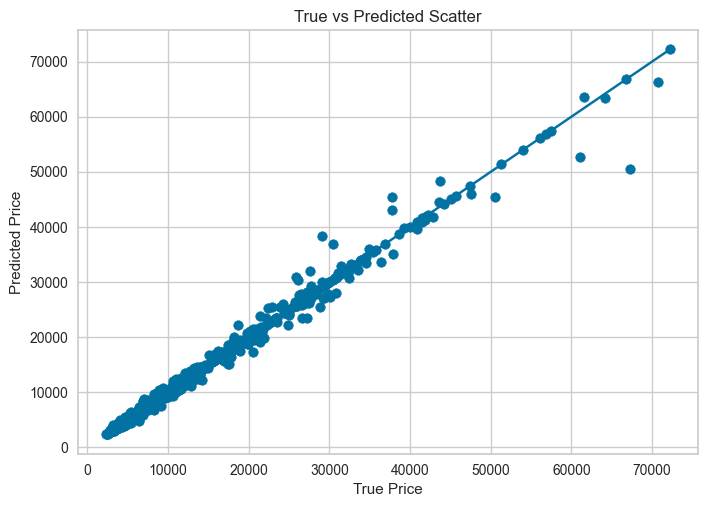

In [35]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(y_true, y_pred)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()])
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('True vs Predicted Scatter')
plt.show()


In [1]:
!pip install tqdm


Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [32]:
import numpy as np
import pandas as pd
from itertools import product
from scipy.optimize import minimize
from tqdm import tqdm
from joblib import Parallel, delayed

# =============================
# 0. 基本参数
# =============================
TARGET = 'Price'
y_target = 8888   # 目标价格
m = 5             # 返回最优解数量
n_sample_combos = 200  # 随机采样的类别组合数量

fixed_cat = {
    #'Cut': 'Ideal', 
    #'Report': 'GIA',
    #'Carat Weight': 1.0
}
search_cat_cols = [
    'Color', 'Clarity', 'Polish', 'Symmetry'
]

model_features = exp.get_config('X_train').columns.tolist()
search_cat_cols = model_features

# =============================
# 1. 获取模型特征
# =============================
model_features = exp.get_config('X_train').columns.tolist()
fixed_cat = {k: v for k, v in fixed_cat.items() if k in model_features}
search_cat_cols = [c for c in search_cat_cols if c in model_features]
num_cols = [c for c in model_features if dataset[c].dtype != 'object']

# =============================
# 2. 类别搜索空间（随机采样）
# =============================
cat_values = {col: dataset[col].unique().tolist() for col in search_cat_cols}
all_combinations = list(product(*cat_values.values()))
if len(all_combinations) > n_sample_combos:
    rng = np.random.default_rng(42)
    sampled_indices = rng.choice(len(all_combinations), size=n_sample_combos, replace=False)
    cat_combinations = [all_combinations[i] for i in sampled_indices]
else:
    cat_combinations = all_combinations

# =============================
# 3. 连续特征边界
# =============================
bounds = [(dataset[col].quantile(0.01), dataset[col].quantile(0.99)) for col in num_cols]

# =============================
# 4. 优化目标函数
# =============================
def objective(x_num, cat_assign):
    row = {col: x_num[i] for i, col in enumerate(num_cols)}
    row.update(fixed_cat)
    row.update(cat_assign)
    x_df = pd.DataFrame([row])
    y_pred = exp.predict_model(best, data=x_df)['prediction_label'].iloc[0]
    return abs(y_pred - y_target) + 0.001 * np.linalg.norm(x_num)

# =============================
# 5. 单个类别组合优化（批量预测 3 个起点）
# =============================
def optimize_single(cat_assign):
    results = []

    # 生成 3 个随机起点
    x0_list = [np.array([np.random.uniform(b[0], b[1]) for b in bounds]) for _ in range(3)]
    
    # 构建批量 DataFrame
    rows = []
    for x0 in x0_list:
        row = {col: x0[i] for i, col in enumerate(num_cols)}
        row.update(fixed_cat)
        row.update(cat_assign)
        if 'Carat Weight' in row:
            row['Carat Weight'] = round(row['Carat Weight'], 2)
        rows.append(row)
    
    x_df = pd.DataFrame(rows)
    
    # 批量预测
    y_preds = exp.predict_model(best, data=x_df)['prediction_label'].values
    
    for i, row in enumerate(rows):
        results.append({**row, 'y_pred': y_preds[i], 'error': abs(y_preds[i] - y_target)})

    return results

# =============================
# 6. 并行优化（线程安全）
# =============================
all_results = Parallel(n_jobs=-1, backend='threading')(
    delayed(optimize_single)(dict(zip(search_cat_cols, combo)))
    for combo in tqdm(cat_combinations, desc="Inverse optimization")
)

# Flatten results
solutions = [item for sublist in all_results for item in sublist]

# =============================
# 7. 输出最优 m 组解
# =============================
result = pd.DataFrame(solutions).sort_values('error').head(m).reset_index(drop=True)
print(result)




Inverse optimization:   0%|                                                                                                               | 0/200 [00:00<?, ?it/s]

Inverse optimization:   8%|████████▏                                                                                             | 16/200 [00:00<00:04, 41.49it/s]

Inverse optimization:  10%|██████████▋                                                                                           | 21/200 [00:01<00:06, 25.59it/s]



Inverse optimization:  12%|████████████▏                                                                                         | 24/200 [00:01<00:12, 14.45it/s]



Inverse optimization:  16%|████████████████▎                                                                                     | 32/200 [00:02<00:16, 10.23it/s]



Inverse optimization:  17%|█████████████████▎                                                                                    | 34/200 [00:02<00:17,  9.59it/s]



Inverse optimization:  20%|████████████████████▍                                                                                 | 40/200 [00:03<00:18,  8.76it/s]

Inverse optimization:  20%|████████████████████▉                                                                                 | 41/200 [00:03<00:18,  8.72it/s]



Inverse optimization:  24%|████████████████████████▍                                                                             | 48/200 [00:04<00:18,  8.25it/s]

Inverse optimization:  24%|████████████████████████▉                                                                             | 49/200 [00:04<00:18,  8.27it/s]

Inverse optimization:  25%|█████████████████████████▌                                                                            | 50/200 [00:04<00:18,  8.24it/s]

Inverse optimization:  26%|██████████████████████████                                                                            | 51/200 [00:05<00:21,  6.93it/s]



Inverse optimization:  28%|████████████████████████████▌                                                                         | 56/200 [00:05<00:16,  8.99it/s]

Inverse optimization:  28%|█████████████████████████████                                                                         | 57/200 [00:05<00:16,  8.79it/s]



Inverse optimization:  29%|█████████████████████████████▌                                                                        | 58/200 [00:05<00:20,  7.08it/s]



Inverse optimization:  30%|██████████████████████████████                                                                        | 59/200 [00:06<00:21,  6.57it/s]



Inverse optimization:  30%|██████████████████████████████▌                                                                       | 60/200 [00:06<00:20,  6.74it/s]

Inverse optimization:  32%|████████████████████████████████▋                                                                     | 64/200 [00:06<00:12, 10.67it/s]

Inverse optimization:  36%|████████████████████████████████████▋                                                                 | 72/200 [00:07<00:15,  8.13it/s]

Inverse optimization:  36%|█████████████████████████████████████▏                                                                | 73/200 [00:07<00:15,  8.03it/s]



Inverse optimization:  40%|████████████████████████████████████████▊                                                             | 80/200 [00:08<00:14,  8.32it/s]



Inverse optimization:  40%|█████████████████████████████████████████▎                                                            | 81/200 [00:08<00:15,  7.75it/s]



Inverse optimization:  44%|████████████████████████████████████████████▉                                                         | 88/200 [00:09<00:13,  8.24it/s]



Inverse optimization:  44%|█████████████████████████████████████████████▍                                                        | 89/200 [00:09<00:13,  8.27it/s]

Inverse optimization:  45%|█████████████████████████████████████████████▉                                                        | 90/200 [00:09<00:13,  8.37it/s]



Inverse optimization:  48%|████████████████████████████████████████████████▉                                                     | 96/200 [00:10<00:13,  7.71it/s]



Inverse optimization:  48%|█████████████████████████████████████████████████▍                                                    | 97/200 [00:10<00:14,  7.13it/s]

Inverse optimization:  52%|████████████████████████████████████████████████████▌                                                | 104/200 [00:11<00:12,  7.69it/s]

Inverse optimization:  52%|█████████████████████████████████████████████████████                                                | 105/200 [00:12<00:13,  7.23it/s]



Inverse optimization:  53%|█████████████████████████████████████████████████████▌                                               | 106/200 [00:12<00:16,  5.70it/s]

Inverse optimization:  56%|████████████████████████████████████████████████████████▌                                            | 112/200 [00:12<00:10,  8.66it/s]

Inverse optimization:  56%|█████████████████████████████████████████████████████████                                            | 113/200 [00:12<00:11,  7.89it/s]



Inverse optimization:  60%|████████████████████████████████████████████████████████████▌                                        | 120/200 [00:13<00:09,  8.82it/s]



Inverse optimization:  64%|████████████████████████████████████████████████████████████████▋                                    | 128/200 [00:14<00:08,  8.02it/s]



Inverse optimization:  64%|█████████████████████████████████████████████████████████████████▏                                   | 129/200 [00:14<00:08,  8.03it/s]

Inverse optimization:  65%|█████████████████████████████████████████████████████████████████▋                                   | 130/200 [00:14<00:08,  7.91it/s]



Inverse optimization:  68%|████████████████████████████████████████████████████████████████████▋                                | 136/200 [00:15<00:08,  7.90it/s]

Inverse optimization:  72%|████████████████████████████████████████████████████████████████████████▋                            | 144/200 [00:16<00:07,  7.95it/s]



Inverse optimization:  76%|████████████████████████████████████████████████████████████████████████████▊                        | 152/200 [00:17<00:06,  7.77it/s]



Inverse optimization:  76%|█████████████████████████████████████████████████████████████████████████████▎                       | 153/200 [00:17<00:06,  7.51it/s]



Inverse optimization:  80%|████████████████████████████████████████████████████████████████████████████████▊                    | 160/200 [00:18<00:05,  7.60it/s]



Inverse optimization:  84%|████████████████████████████████████████████████████████████████████████████████████▊                | 168/200 [00:19<00:04,  7.72it/s]



Inverse optimization:  84%|█████████████████████████████████████████████████████████████████████████████████████▎               | 169/200 [00:19<00:03,  7.78it/s]



Inverse optimization:  88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 176/200 [00:21<00:03,  7.23it/s]



Inverse optimization:  92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 184/200 [00:21<00:02,  7.77it/s]



Inverse optimization:  96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 192/200 [00:22<00:01,  7.74it/s]



Inverse optimization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  7.54it/s]

Inverse optimization: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.31it/s]


   Carat Weight   Cut Color Clarity Polish Symmetry Report   y_pred  error
0          1.54  Fair     I     SI1      G        G   AGSL  8841.92  46.08
1          1.54  Fair     I     SI1      G        G   AGSL  8841.92  46.08
2          1.54  Fair     I     SI1      G        G   AGSL  8841.92  46.08
3          1.26  Fair     G     VS2     EX       EX   AGSL  8939.91  51.91
4          1.26  Fair     G     VS2     EX       EX   AGSL  8939.91  51.91


In [33]:
result

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,y_pred,error
0,1.54,Fair,I,SI1,G,G,AGSL,8841.92,46.08
1,1.54,Fair,I,SI1,G,G,AGSL,8841.92,46.08
2,1.54,Fair,I,SI1,G,G,AGSL,8841.92,46.08
3,1.26,Fair,G,VS2,EX,EX,AGSL,8939.91,51.91
4,1.26,Fair,G,VS2,EX,EX,AGSL,8939.91,51.91


In [36]:
data

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...
5895,1.22,Ideal,I,VS2,VG,VG,GIA,6137
5896,1.52,Ideal,H,IF,EX,EX,GIA,13744
5897,0.90,Very Good,H,VS2,EX,EX,GIA,4258
5898,1.04,Very Good,H,SI1,EX,EX,GIA,5285
